In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 데이터셋 로드
file_path = 'hw7_dataset.csv'  
dataset = pd.read_csv(file_path, encoding='ISO-8859-1')

# 필요한 열만 선택
dataset = dataset[['v1', 'v2']]

# 라벨 인코딩 (Spam: 1, Ham: 0)
dataset['v1'] = dataset['v1'].map({'spam': 1, 'ham': 0})

# 데이터셋 분할 (train: 70%, validation: 10%, test: 20%)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['v2'])

# 시퀀스 변환 및 패딩
max_length = 100
train_sequences = tokenizer.texts_to_sequences(train['v2'])
train_padded = pad_sequences(train_sequences, maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(val['v2'])
val_padded = pad_sequences(val_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test['v2'])
test_padded = pad_sequences(test_sequences, maxlen=max_length)


Epoch 1/10
61/61 [==============================] - 8s 108ms/step - loss: 0.4032 - accuracy: 0.8669 - val_loss: 0.1698 - val_accuracy: 0.9659
Epoch 2/10
61/61 [==============================] - 6s 101ms/step - loss: 0.0729 - accuracy: 0.9838 - val_loss: 0.0715 - val_accuracy: 0.9803
Epoch 3/10
61/61 [==============================] - 6s 105ms/step - loss: 0.0268 - accuracy: 0.9941 - val_loss: 0.0841 - val_accuracy: 0.9803
Epoch 4/10
61/61 [==============================] - 6s 104ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 0.0898 - val_accuracy: 0.9839
Epoch 5/10
35/35 [==============================] - 0s 10ms/step - loss: 0.0921 - accuracy: 0.9821
Test Accuracy: 0.9820627570152283
35/35 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99     

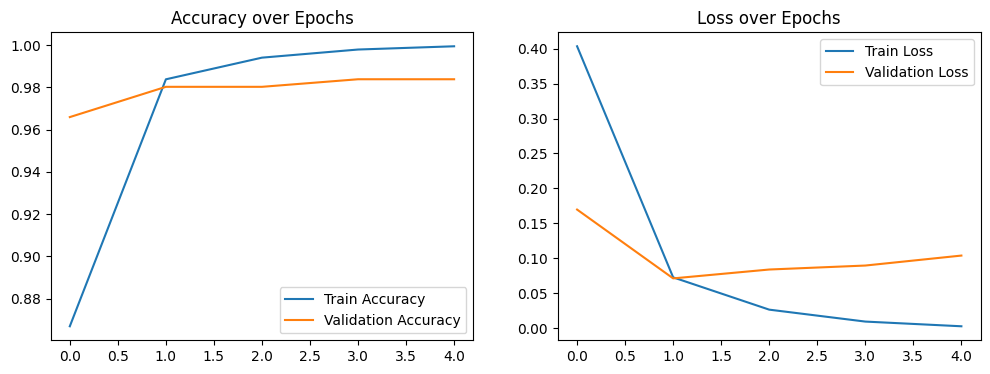

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 모델 구성
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping 적용
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습
history = model.fit(train_padded, train['v1'], 
                    epochs=10, 
                    batch_size=64, 
                    validation_data=(val_padded, val['v1']), 
                    callbacks=[early_stopping])

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test_padded, test['v1'])
print(f"Test Accuracy: {test_accuracy}")

# 테스트 데이터에 대한 예측 수행
predictions = model.predict(test_padded)
predictions = (predictions > 0.5).astype(int)
print(classification_report(test['v1'], predictions))

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()
